In [68]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys

import pymaster as nmt

#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
sys.path.insert(0, '..')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [3]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16

matplotlib.rc('text', usetex=True)

In [5]:
color_quaia = 'mediumvioletred'
color_catwise = 'teal'
lw = 2
lw_grid = 0.5

### functions

In [267]:
def C_1(dipole_amplitude):  # from the new Abghari et al. (including Douglas Scott), eq. 3.3
    # return dipole_amplitude**2 / 3
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

def D_err(C_1, C_1_err):
    # Calculate the derivative of D with respect to C_1
    # D(C_1) = 9 * sqrt(C_1) / (4 * pi)
    # dD/dC_1 = (9 / (4 * pi)) * (1 / (2 * sqrt(C_1)))
    dD_dC1 = (9 / (4 * np.pi)) * (1 / (2 * np.sqrt(C_1)))
    
    # Propagate the error
    D_err_ = abs(dD_dC1) * C_1_err
    
    return D_err_
    

In [7]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk_Wmask(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map_Wmask(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells
def Cells_for_jk_Lambda(overdensity_map, Lambda, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map, Lambda, max_ell, selfunc=selfunc)
    return Cells

### load samples and construct overdensity maps

In [11]:
# some key variables !!

# ABBY
datadir = '/scratch/aew492/quasars'
# catdir = '/scratch/aew492/quasars/catalogs'
# selfuncdir_quaia = os.path.join(catdir, 'quaia/selfuncs')
# selfuncdir_catwise = os.path.join(catdir, 'catwise_agns/selfuncs')

# KSF
datadir = '../../quasar_data_abby'
catdir =  '../../quasar_data_abby/catalogs'
selfuncdir_quaia = '../../gaia-quasars-lss/data/maps/'
selfuncdir_catwise = '../../gaia-quasars-lss/data/maps/'

mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')

In [106]:
# regularization
Wmask = 0.1  # rough fiducial Wmask

# Lambda_quaia based on matching shot noise dipole on the cut and full sky; dependent on ell max
# **for Quaia only right now - I need to check that CatWISE gives similar results
Lambdas_dict_quaia = np.load(f'{datadir}/regularization/Lambdas_quaia_noise-matched.npy', allow_pickle=True).item()
Lambdas_dict_catwise = np.load(f'{datadir}/regularization/Lambdas_catwise_noise-matched.npy', allow_pickle=True).item()
max_ell = 8  # max ell to fit
Lambda_quaia = Lambdas_dict_quaia[max_ell]
Lambda_catwise = Lambdas_dict_catwise[max_ell]
Lambda_quaia, Lambda_catwise

(0.005011872336272725, 0.005011872336272725)

In [107]:
Lambdas_dict_quaia, Lambdas_dict_catwise

({1: 0.018197008586099832,
  2: 0.018197008586099832,
  3: 0.013182567385564073,
  4: 0.013182567385564073,
  5: 0.007244359600749898,
  6: 0.007244359600749898,
  7: 0.004365158322401661,
  8: 0.005011872336272725},
 {1: 0.017378008287493755,
  2: 0.017378008287493755,
  3: 0.013182567385564073,
  4: 0.013182567385564073,
  5: 0.007585775750291836,
  6: 0.007585775750291836,
  7: 0.004570881896148751,
  8: 0.005011872336272725})

#### CatWISE

In [109]:
# instantiate dipole object:
d_catwise = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              #basedir=basedir,
              blim=30)
d_catwise.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d_catwise.table, maglimit=d_catwise.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d_catwise.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 4481299 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400868 sources left.


In [191]:
# at the healpix level:

# load selection function
# selfunc_catwise = d_catwise.get_selfunc(os.path.join(catdir, 'catwise_agns/selfuncs',
#                                             f'selection_function_NSIDE{d_catwise.NSIDE}_catwise_pluszodis.fits'))
selfunc_catwise = d_catwise.get_selfunc(os.path.join(selfuncdir_catwise,
                                            f'selection_function_NSIDE{d_catwise.NSIDE}_catwise_pluszodis.fits'))

# construct overdensity map with no selection function
overdensity_map_catwise = d_catwise.construct_overdensity_map(selfunc=None)

# and with the selection function
overdensity_map_sf_catwise = d_catwise.construct_overdensity_map(selfunc=selfunc_catwise)

constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
constructing overdensity map


In [223]:
# for CatWISE, we also want to correct for a density trend in ecliptic latitude, to match Secrest:
# get the ecliptic latitudes of each healpixel
lon, lat = hp.pix2ang(d_catwise.NSIDE, np.arange(hp.nside2npix(d_catwise.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# construct the masked datamap
masked_datamap = d_catwise.construct_masked_datamap(selfunc=None, return_map=True)

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
print(p)
# correct the densities and fit to the corrected densities
vals_elatcorr = - np.polyval(p, np.abs(elat.value)) + p[1]
map_elatcorr = masked_datamap + vals_elatcorr
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1) # in case we want to check the corrected trend
# then the overdensity map is
overdensity_map_elat_catwise = map_elatcorr / np.nanmean(map_elatcorr) - 1

selection function not provided; assuming completeness = 1 in every pixel
[-4.14916266e-02  5.77477631e+01]


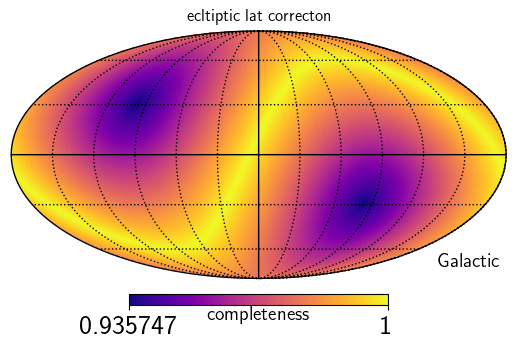

In [228]:
selfunc_catwise_elat = np.nanmean(map_elatcorr)-vals_elatcorr
selfunc_catwise_elat /= np.max(selfunc_catwise_elat)

fig = plt.figure(figsize=(16,3))
hp.mollview(selfunc_catwise_elat, coord=['C','G'], 
            #min=30, max=100, 
            badcolor='w', fig=fig, sub=(1,3,1), cmap='plasma',
            unit='completeness', title=f'ecltiptic lat correcton')
hp.graticule()

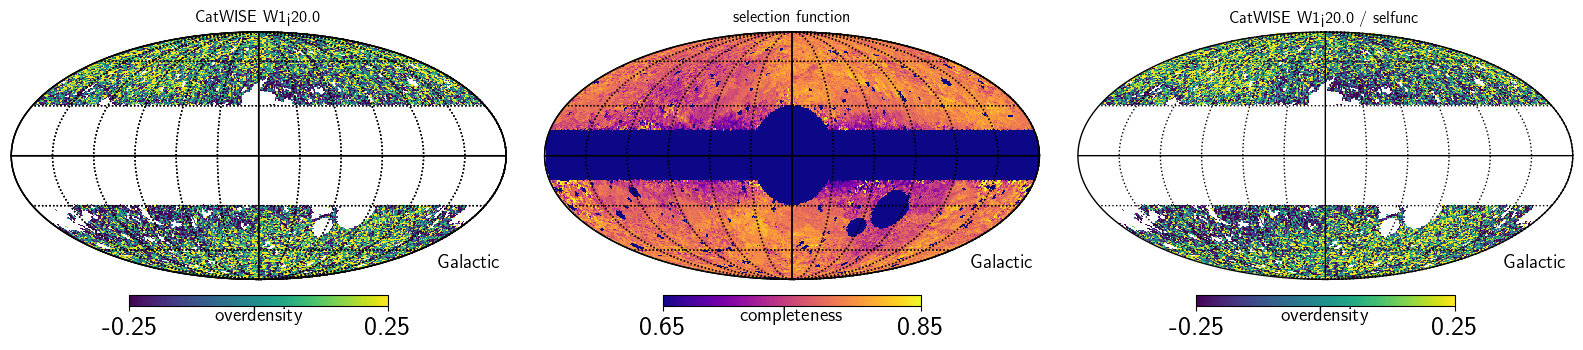

In [112]:
# plot to compare
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_catwise, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'CatWISE W1<{d_catwise.maglim}')
hp.graticule()
hp.mollview(selfunc_catwise, coord=['C','G'], min=0.65, max=0.85, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()
hp.mollview(overdensity_map_sf_catwise, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,3),
            unit='overdensity', title=f'CatWISE W1<{d_catwise.maglim} / selfunc')
hp.graticule()

#### Quaia

In [113]:
# instantiate dipole object:
d_quaia = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d_quaia.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d_quaia.table, maglimit=d_quaia.maglim,
                                                            min_g=19.5, max_g=20.5)  # reasonable min and max around the magnitude limit
d_quaia.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 917917 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530559 sources left.


In [114]:
# at the healpix level:

# load selection function
selfunc_quaia_blim15 = d_quaia.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d_quaia.NSIDE}_G{d_quaia.maglim}_blim15.fits')) # note the blim15 !
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_blim15 = d_quaia.construct_overdensity_map(selfunc=selfunc_quaia_blim15)

constructing overdensity map


In [115]:
# at the healpix level:

# load selection function
selfunc_quaia_full = d_quaia.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d_quaia.NSIDE}_G{d_quaia.maglim}.fits'))
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_full = d_quaia.construct_overdensity_map(selfunc=selfunc_quaia_full)

constructing overdensity map


In [116]:
# at the healpix level:

# load selection function
selfunc_quaia_fullzodis = d_quaia.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d_quaia.NSIDE}_G{d_quaia.maglim}_pluszodis.fits'))
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_fullzodis = d_quaia.construct_overdensity_map(selfunc=selfunc_quaia_fullzodis)

constructing overdensity map


In [117]:
# CHOOSE FIDUCIAL QUAIA SELFUNC
selfunc_quaia = selfunc_quaia_full
overdensity_map_sf_quaia = overdensity_map_sf_quaia_full

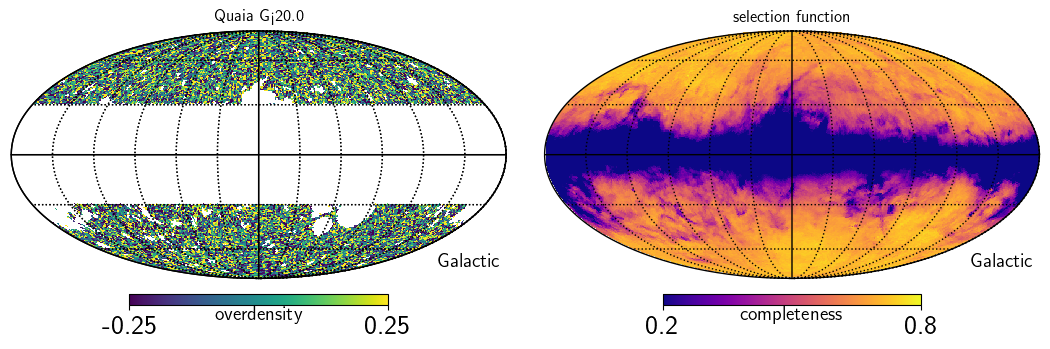

In [23]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d_quaia.maglim}')
hp.graticule()
hp.mollview(selfunc_quaia, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

### dipoles, Cells, etc !

#### jackknife subsamples

In [24]:
nsamples = 12
lonavg, subsamples_catwise = get_longitude_subsamples_from_hpmap(overdensity_map_elat_catwise, nsamples, input_frame='icrs')
lonavg, subsamples_sf_catwise = get_longitude_subsamples_from_hpmap(overdensity_map_sf_catwise, nsamples, input_frame='icrs')
lonavg, subsamples_quaia = get_longitude_subsamples_from_hpmap(overdensity_map_sf_quaia, nsamples, input_frame='icrs')
jk_subsamples = [subsamples_catwise, subsamples_sf_catwise, subsamples_quaia]

#### measure dipoles in each overdensity map

In [25]:
# CatWISE WITH WMASK
# no selection function, ecliptic latitude density correction
comps_catwise = dipole.measure_dipole_in_overdensity_map_Wmask(overdensity_map_elat_catwise, Wmask=Wmask, selfunc=None)
print(dipole.get_dipole(comps_catwise))  # turns the 3 dipole components into an amplitude and direction
# selection function
comps_sf_catwise = dipole.measure_dipole_in_overdensity_map_Wmask(overdensity_map_sf_catwise, Wmask=Wmask, selfunc=selfunc_catwise)
print(dipole.get_dipole(comps_sf_catwise))

# Quaia
comps_quaia = dipole.measure_dipole_in_overdensity_map_Wmask(overdensity_map_sf_quaia, Wmask=Wmask, selfunc=selfunc_quaia)
print(dipole.get_dipole(comps_quaia))

# checking 
comps_quaia_blim15 = dipole.measure_dipole_in_overdensity_map_Wmask(overdensity_map_sf_quaia_blim15, Wmask=Wmask, selfunc=selfunc_quaia)
print(dipole.get_dipole(comps_quaia_blim15))

comps_quaia_full = dipole.measure_dipole_in_overdensity_map_Wmask(overdensity_map_sf_quaia_full, Wmask=Wmask, 
                                                            selfunc=selfunc_quaia_full)
print(dipole.get_dipole(comps_quaia_full))

comps_quaia_fullzodis = dipole.measure_dipole_in_overdensity_map_Wmask(overdensity_map_sf_quaia_fullzodis, Wmask=Wmask, 
                                                            selfunc=selfunc_quaia_fullzodis)
print(dipole.get_dipole(comps_quaia_fullzodis))

selection function not provided; assuming completeness = 1 everywhere
(0.012920356325039108, <SkyCoord (ICRS): (ra, dec) in deg
    (143.91505683, -3.23421602)>)
(0.01051855007176703, <SkyCoord (ICRS): (ra, dec) in deg
    (136.19854022, 32.79233672)>)
(0.011424522282292342, <SkyCoord (ICRS): (ra, dec) in deg
    (205.68958834, -25.26348363)>)
(0.01341820137426371, <SkyCoord (ICRS): (ra, dec) in deg
    (198.6279897, -25.09851362)>)
(0.011424522282292342, <SkyCoord (ICRS): (ra, dec) in deg
    (205.68958834, -25.26348363)>)
(0.009000227835489311, <SkyCoord (ICRS): (ra, dec) in deg
    (188.15235878, -24.41619683)>)


In [26]:
# CatWISE WITH Lambda_quaia
# no selection function, ecliptic latitude density correction
comps_catwise = dipole.measure_dipole_in_overdensity_map_Lambda(overdensity_map_elat_catwise, Lambda=Lambda_catwise, selfunc=None)
print(dipole.get_dipole(comps_catwise))  # turns the 3 dipole components into an amplitude and direction
# selection function
comps_sf_catwise = dipole.measure_dipole_in_overdensity_map_Lambda(overdensity_map_sf_catwise, Lambda=Lambda_catwise, selfunc=selfunc_catwise)
print(dipole.get_dipole(comps_sf_catwise))

# Quaia
comps_quaia = dipole.measure_dipole_in_overdensity_map_Lambda(overdensity_map_sf_quaia, Lambda=Lambda_catwise, selfunc=selfunc_quaia)
print(dipole.get_dipole(comps_quaia))

# checking 
comps_quaia_blim15 = dipole.measure_dipole_in_overdensity_map_Lambda(overdensity_map_sf_quaia_blim15, Lambda=Lambda_catwise, selfunc=selfunc_quaia)
print(dipole.get_dipole(comps_quaia_blim15))

comps_quaia_full = dipole.measure_dipole_in_overdensity_map_Lambda(overdensity_map_sf_quaia_full, Lambda=Lambda_quaia, 
                                                            selfunc=selfunc_quaia_full)
print(dipole.get_dipole(comps_quaia_full))

comps_quaia_fullzodis = dipole.measure_dipole_in_overdensity_map_Lambda(overdensity_map_sf_quaia_fullzodis, Lambda=Lambda_quaia, 
                                                            selfunc=selfunc_quaia_fullzodis)
print(dipole.get_dipole(comps_quaia_fullzodis))

selection function not provided; assuming completeness = 1 everywhere
(0.014502645132574472, <SkyCoord (ICRS): (ra, dec) in deg
    (140.61696779, -5.88934815)>)
(0.011858676869155, <SkyCoord (ICRS): (ra, dec) in deg
    (129.86765509, 32.01715669)>)
(0.014124564885564517, <SkyCoord (ICRS): (ra, dec) in deg
    (208.46722098, -31.79597863)>)
(0.016449316689402377, <SkyCoord (ICRS): (ra, dec) in deg
    (200.62488861, -31.98763162)>)
(0.014124564885564517, <SkyCoord (ICRS): (ra, dec) in deg
    (208.46722098, -31.79597863)>)
(0.010930670876434618, <SkyCoord (ICRS): (ra, dec) in deg
    (188.72551282, -31.52104501)>)


#### measure Cells up to some $\ell_\mathrm{max}$

In [27]:
# max ell defined at the top of the notebook

In [28]:
# measure the Cells from the overdensity maps:
# CatWISE
ells, Cells_catwise = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_elat_catwise,
                                                          Lambda=Lambda_catwise, max_ell=max_ell, selfunc=None)
ells, Cells_sf_catwise = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                          Lambda=Lambda_catwise, max_ell=max_ell, selfunc=selfunc_catwise)
# Quaia
ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                          Lambda=Lambda_quaia, max_ell=max_ell, selfunc=selfunc_quaia)

In [31]:
# JACKKNIFE:
#  for max_ell = 8 with 12 subsamples this took ~15 min to run, so I went ahead and saved the uncertainty results to load in

#Cells_catwise_std = compute_jackknife_uncertainty(subsamples_catwise, Cells_for_jk_Lambda,
#                                                  Lambda=Lambda_quaia, max_ell=max_ell, selfunc=None)
#Cells_sf_catwise_std = compute_jackknife_uncertainty(subsamples_sf_catwise, Cells_for_jk_Lambda,
#                                                     Lambda=Lambda_quaia, max_ell=max_ell, selfunc=selfunc_catwise)
#Cells_quaia_std = compute_jackknife_uncertainty(Lambda, Cells_for_jk_Lambda,
#                                                     Lambda=Lambda_quaia, max_ell=max_ell, selfunc=selfunc_quaia)
save_dir = f'{datadir}/jackknife'
#ells = np.arange(max_ell+1)
#save_dict = dict(ells=ells, Cells_std=Cells_catwise_std, subsamples=subsamples_catwise, Lambda_quaia=Lambda_catwise, selfunc=None)
#np.save(os.path.join(save_dir, f'jk_Cells_std_catwise_elatcorr_ellmax{max_ell}_Lambda-{Lambda_catwise:.3f}.npy'), save_dict)
#save_dict = dict(ells=ells, Cells_std=Cells_sf_catwise_std, subsamples=subsamples_sf_catwise, Lambda_quaia=Lambda_catwise, selfunc=selfunc_catwise)
#np.save(os.path.join(save_dir, f'jk_Cells_std_catwise_sfcorr_ellmax{max_ell}_Lambda-{Lambda_catwise:.3f}.npy'), save_dict)
#save_dict = dict(ells=ells, Cells_std=Cells_quaia_std, subsamples=subsamples_quaia, Lambda_quaia=Lambda_quaia, selfunc=selfunc_quaia)
#np.save(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}_Lambda-{Lambda_quaia:.3f}.npy'), save_dict)

In [32]:
Cells_catwise_std = np.load(os.path.join(save_dir, f'jk_Cells_std_catwise_elatcorr_ellmax{max_ell}_Lambda-{Lambda_catwise:.3f}.npy'),
                            allow_pickle=True).item()['Cells_std']
Cells_sf_catwise_std = np.load(os.path.join(save_dir, f'jk_Cells_std_catwise_sfcorr_ellmax{max_ell}_Lambda-{Lambda_catwise:.3f}.npy'),
                            allow_pickle=True).item()['Cells_std']
Cells_quaia_std = np.load(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}_Lambda-{Lambda_quaia:.3f}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [34]:
# load in shot noise estimates (@ Kate you should have access on Greene, if not let me know)
# on the full sky, only fitting up to the dipole
noise_dir = f'{datadir}/noise_Cells'

res_catwise = np.load(f'{noise_dir}/catwise_agns/noise_Cells_fullsky_ellmax1_10000trials.npy', allow_pickle=True).item()
noise_catwise_Cell = res_catwise['Cells_fullsky'][0]
res_quaia = np.load(f'{noise_dir}/quaia/noise_Cells_fullsky_ellmax1_10000trials.npy', allow_pickle=True).item()
noise_quaia_Cell = res_quaia['Cells_fullsky'][0]

print(noise_catwise_Cell, noise_quaia_Cell)

[1.81015764e-06] [7.53507036e-06]


## Namaster C_ells

In [133]:
# Bins
#b = nmt.NmtBin(d_quaia.NSIDE, nlb=30)
l_max = max_ell
ells_nmt = np.arange(1, l_max+1)
bpws = np.arange(len(ells_nmt))
weights = np.ones(len(ells_nmt))/len(ells_nmt)
b = nmt.NmtBin(d_quaia.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
#b = nmt.NmtBin(d_quaia.NSIDE, nlb=1, lmax=3)

leff = b.get_effective_ells()
print(leff)

[1. 2. 3. 4. 5. 6. 7. 8.]


In [134]:
# Calculator
def get_cl(f1, f2, b, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

In [135]:
def get_cov(f1, f2, f3, f4, w12, w34):
    fs = [f1, f2, f3, f4]
    ms = [f.get_mask() for f in fs]
    # Compute all pseudo-Cls
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j])
                     for i in range(4)] for j in range(4)])
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

### Quaia

In [ ]:
masked_datamap_quaia = d_quaia.construct_masked_datamap(selfunc=selfunc_quaia, return_map=True)

In [137]:
map_quaia = overdensity_map_sf_quaia.copy()
map_quaia[np.isnan(map_quaia)] = 0

In [138]:
NPIX = hp.nside2npix(d_quaia.NSIDE)

# mask_sf is the selection function with the binary mask masked out; d_quaia.mask is the binary mask
mask_sf = selfunc_quaia.copy()
mask_sf[~d_quaia.mask] = 0.0

In [139]:
# Abby computed the overdensity map with the mean like this
nmean_meanmethodAbby = np.sum(d_quaia.datamap[d_quaia.mask]/(mask_sf[d_quaia.mask]))/np.sum(d_quaia.mask)
nmean_srad_meanmethodAbby = nmean_meanmethodAbby * NPIX / (4*np.pi)
nl_coupled_meanmethodAbby = np.mean(mask_sf) / nmean_srad_meanmethodAbby * np.ones((1, 3*d_quaia.NSIDE))

In [140]:
f_quaia = nmt.NmtField(mask_sf, [map_quaia], n_iter=0)

In [154]:
cl_quaia, nl_quaia, w_quaia, Bbl_quaia = get_cl(f_quaia, f_quaia, b, 
                        pnl=nl_coupled_meanmethodAbby)
print(cl)

[[ 1.98187274e-04 -2.37026706e-06 -3.00864366e-05 -4.80878085e-06
   4.89024542e-05  2.71657585e-05  2.25808882e-05  1.09803928e-05]]


In [237]:
f = f_quaia
w = w_quaia
cv_quaia = get_cov(f, f, f, f, w, w)

### Catwise

In [199]:
masked_datamap_catwise = d_catwise.construct_masked_datamap(selfunc=selfunc_catwise, return_map=True)

In [200]:
np.allclose(masked_datamap_catwise[d_catwise.mask], d_catwise.datamap[d_catwise.mask])

False

In [201]:
np.allclose(d_catwise.mask, d_quaia.mask)
np.sum(d_catwise.mask), np.sum(d_quaia.mask)

(23562, 22165)

In [202]:
masked_datamap_catwise[d_catwise.mask]

array([73.7241799 , 67.86625493, 60.75586978, ..., 62.37841916,
       74.12566228, 59.71402936])

In [203]:
print(d_catwise.datamap[d_catwise.mask])
print(mask_sf_catwise[d_catwise.mask])

[55. 49. 46. ... 47. 57. 46.]
[0.7460239  0.72200831 0.75712849 ... 0.75346571 0.76896446 0.77033824]


In [204]:
map_catwise = overdensity_map_sf_catwise.copy()
map_catwise[np.isnan(map_catwise)] = 0

In [205]:
print(np.sum(d_catwise.mask))
print(map_catwise[d_catwise.mask])

23562
[ 0.01763686 -0.06322182 -0.16136859 ... -0.13897206  0.02317864
 -0.17574943]


To compute nl_coupled, we need the mean, so we need to go back to the number counts datamap::

In [206]:
NPIX = hp.nside2npix(d_catwise.NSIDE)

# mask_sf is the selection function with the binary mask masked out; d_catwise.mask is the binary mask
mask_sf_catwise = selfunc_catwise.copy()
mask_sf_catwise[~d_catwise.mask] = 0.0

In [207]:
# Abby computed the overdensity map with the mean like this
nmean_catwise_meanmethodAbby = np.sum(d_catwise.datamap[d_catwise.mask]/(mask_sf_catwise[d_catwise.mask]))/np.sum(d_catwise.mask)
nmean_srad_catwise_meanmethodAbby = nmean_catwise_meanmethodAbby * NPIX / (4*np.pi)
nl_coupled_catwise_meanmethodAbby = np.mean(mask_sf_catwise) / nmean_srad_catwise_meanmethodAbby * np.ones((1, 3*d_catwise.NSIDE))

In [208]:
nl_coupled_catwise_meanmethodAbby[0][0]

1.3198939128187863e-06

In [209]:
f_catwise = nmt.NmtField(mask_sf_catwise, [map_catwise], n_iter=0)

In [210]:
cl_catwise, nl_catwise, w_catwise, Bbl_catwise = get_cl(f_catwise, f_catwise, b, 
                        pnl=nl_coupled_catwise_meanmethodAbby)
print(cl_catwise)

[[ 2.06496392e-04  5.94463215e-06  1.83060518e-06  3.71771776e-05
   6.57509174e-06  2.47538865e-06 -3.96194623e-06  7.10530441e-06]]


Covariance computation:

In [238]:
f = f_catwise
w = w_catwise
cv_catwise = get_cov(f, f, f, f, w, w)

### CatWISE elatcorr

In [225]:
map_catwise_elat = overdensity_map_elat_catwise.copy()
map_catwise_elat[np.isnan(map_catwise_elat)] = 0

To compute nl_coupled, we need the mean, so we need to go back to the number counts datamap::

In [229]:
NPIX = hp.nside2npix(d_catwise.NSIDE)

# mask_sf is the selection function with the binary mask masked out; d.mask is the binary mask
mask_sf_catwise_elat = selfunc_catwise_elat.copy()
#mask_sf_catwise_elat = np.ones(len(map_catwise_elat))
mask_sf_catwise_elat[~d_catwise.mask] = 0.0

In [230]:
# Abby computed the overdensity map with the mean like this
nmean_catwise_elat_meanmethodAbby = np.sum(d_catwise.datamap[d_catwise.mask]/(mask_sf_catwise_elat[d_catwise.mask]))/np.sum(d_catwise.mask)
nmean_srad_catwise_elat_meanmethodAbby = nmean_catwise_meanmethodAbby * NPIX / (4*np.pi)
nl_coupled_catwise_elat_meanmethodAbby = np.mean(mask_sf_catwise) / nmean_srad_catwise_meanmethodAbby * np.ones((1, 3*d_catwise.NSIDE))

In [231]:
f_catwise_elat = nmt.NmtField(mask_sf_catwise_elat, [map_catwise_elat], n_iter=0)

In [232]:
cl_catwise_elat, nl_catwise_elat, w_catwise_elat, Bbl_catwise = get_cl(f_catwise_elat, f_catwise_elat, b, 
                        pnl=nl_coupled_catwise_elat_meanmethodAbby)
print(cl_catwise_elat)

[[ 2.59468954e-04  1.06482177e-05 -1.46748116e-07  3.32718874e-05
   6.41120750e-06 -8.45673960e-07  1.65870861e-06  1.23239605e-05]]


Covariance computation:

In [239]:
f = f_catwise_elat
w = w_catwise_elat
cv_catwise_elat = get_cov(f, f, f, f, w, w)

## Plotting C_ells

In [37]:
# and best-fit model from David, cutting to only the relevant ells
fn_model = f'{datadir}/quaia_PS/cl_gg_bf_G20.0_1bin.npz'
with np.load(fn_model) as res:
    ells_mod = res['ell']
    Cells_mod = res['cl_gg']
idx = ells_mod <= max_ell
ells_mod, Cells_mod = ells_mod[idx], Cells_mod[idx]

In [38]:
# expected dipole amplitudes C_1
expected_C1_catwise = C_1(expected_dipamp_catwise)
expected_C1_quaia = C_1(expected_dipamp_quaia)

In [39]:
print(Cells_catwise)
print(Cells_sf_catwise)

[9.09153576e-06 9.97394761e-05 1.36050184e-05 2.23223911e-05
 8.41629358e-06 1.90771961e-05 1.35950515e-05 1.76321044e-05
 1.51394337e-05]
[5.74279853e-08 6.16497106e-05 6.61163543e-06 1.41452622e-05
 1.14245723e-05 9.95701853e-06 9.26116112e-06 6.41297831e-06
 6.33883741e-06]


In [40]:
noise_quaia_cross = 1.2e-5

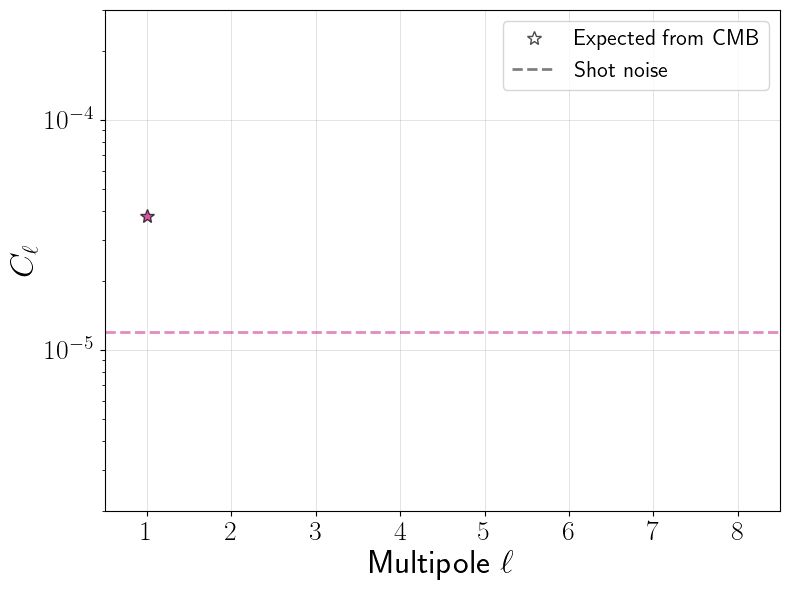

In [41]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
#ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)
#ax.plot(ells_mod, Cells_mod + noise_quaia_cross, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

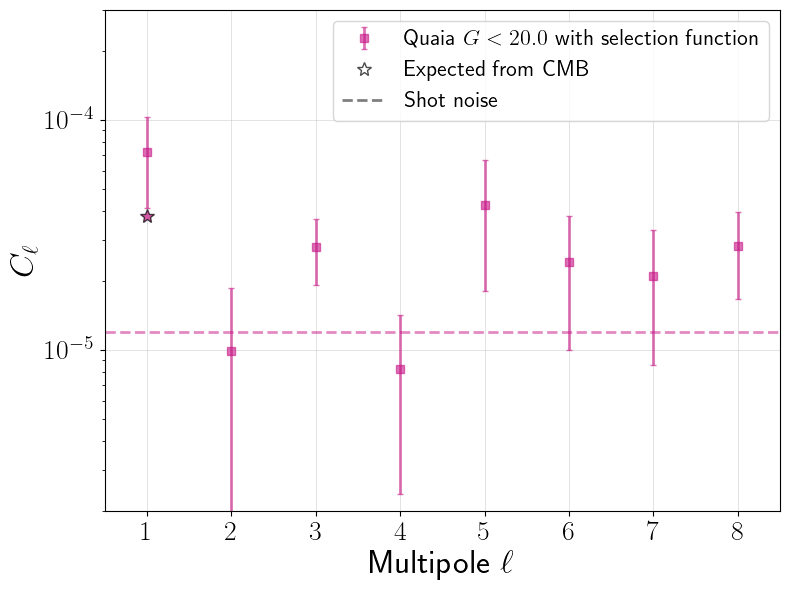

In [42]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Quaia $G<20.0$ with selection function', marker='s', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
#ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

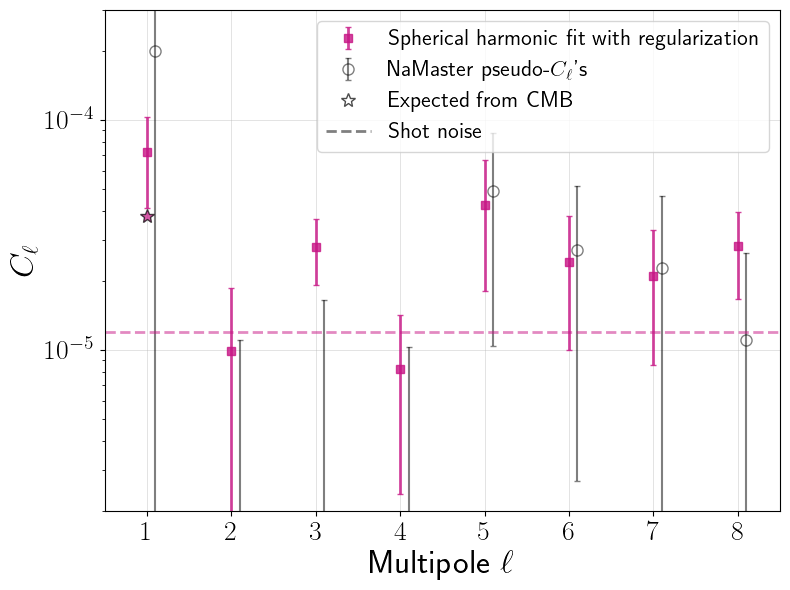

In [247]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.8, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Spherical harmonic fit with regularization', marker='s', **kwargs)

ax.errorbar(leff+0.1, cl_quaia[0], yerr=np.sqrt(np.diag(cv_quaia)),
            color='k', alpha=0.5, marker='o', markersize=8, markerfacecolor='None',
            ls='None', capsize=2,
            label=r"NaMaster pseudo-$C_\ell$'s")

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
#ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

In [43]:
print(noise_catwise_Cell, noise_quaia_Cell)
# a cursed estimate, for now
noise_catwise_cross = noise_quaia_cross * noise_catwise_Cell/noise_quaia_Cell
print(noise_catwise_cross, noise_quaia_cross)

[1.81015764e-06] [7.53507036e-06]
[2.88277224e-06] 1.2e-05


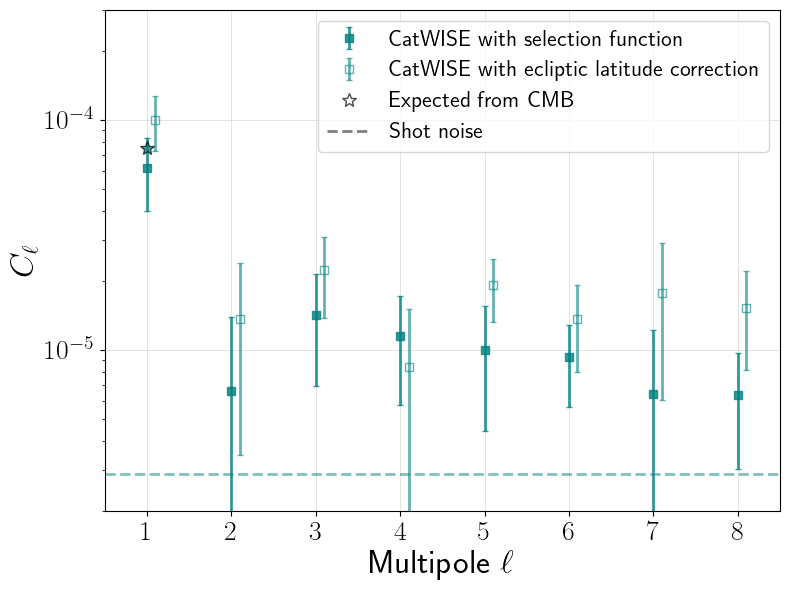

In [244]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_sf_catwise[1:], alpha=0.8, yerr=Cells_sf_catwise_std[1:],
            label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
ax.errorbar(ells[1:]+0.1, Cells_catwise[1:], alpha=0.6, yerr=Cells_catwise_std[1:],
        label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='s', markerfacecolor='None', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_catwise_cross, c=color_catwise, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

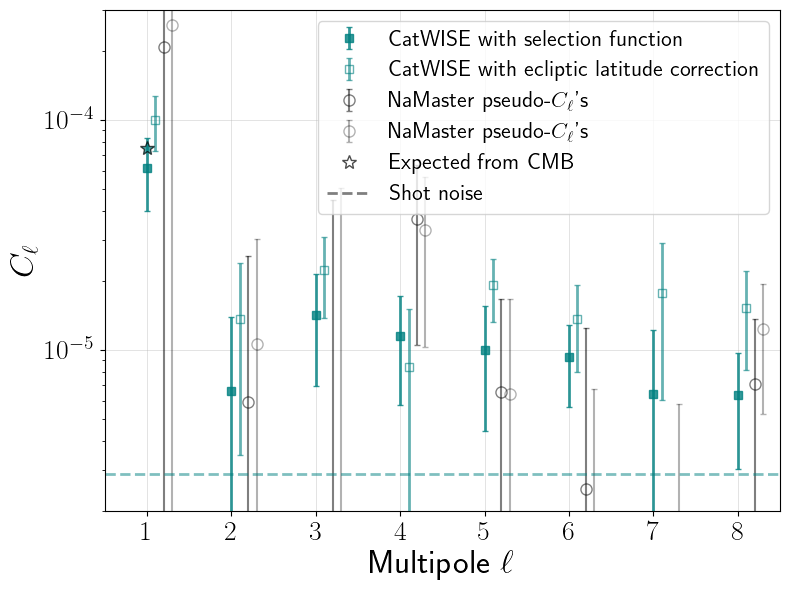

In [246]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_sf_catwise[1:], alpha=0.8, yerr=Cells_sf_catwise_std[1:],
            label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
eb = ax.errorbar(ells[1:]+0.1, Cells_catwise[1:], alpha=0.6, yerr=Cells_catwise_std[1:],
        label='CatWISE with ecliptic latitude correction', c=color_catwise, 
            marker='s', markerfacecolor='None', **kwargs)
#eb[-1][0].set_linestyle('--')

# r'Spherical harmonic fit with regularization'

ax.errorbar(leff+0.2, cl_catwise[0], yerr=np.sqrt(np.diag(cv_catwise)),
            color='k', alpha=0.5, marker='o', markersize=8, markerfacecolor='None',
            ls='None', capsize=2,
            label=r"NaMaster pseudo-$C_\ell$'s")

ax.errorbar(leff+0.3, cl_catwise_elat[0], yerr=np.sqrt(np.diag(cv_catwise_elat)),
            color='k', alpha=0.3, marker='o', markersize=8, markerfacecolor='None',
            ls='None', capsize=2,
            label=r"NaMaster pseudo-$C_\ell$'s")

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_catwise_cross, c=color_catwise, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

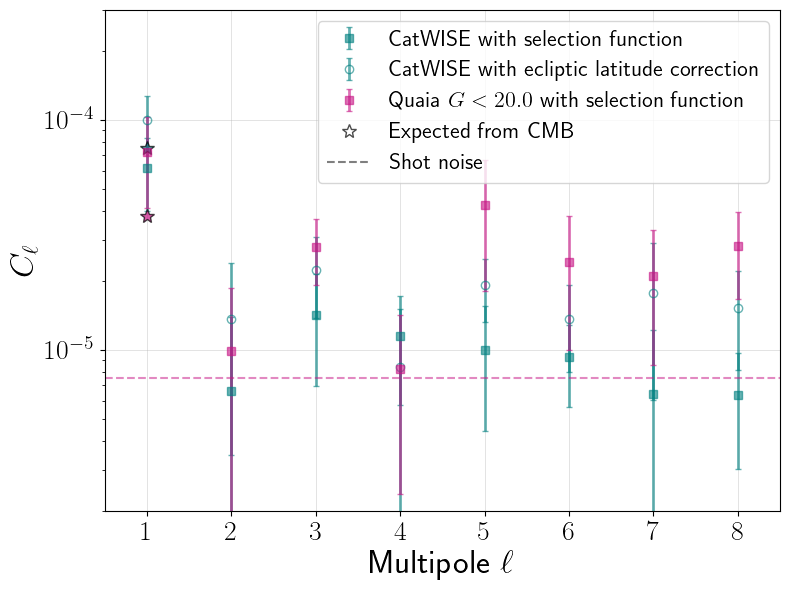

In [45]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_sf_catwise[1:], yerr=Cells_sf_catwise_std[1:],
            label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
ax.errorbar(ells[1:], Cells_catwise[1:], yerr=Cells_catwise_std[1:],
        label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='o', markerfacecolor='None', **kwargs)
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Quaia $G<20.0$ with selection function', marker='s', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5)
ax.axhline(noise_catwise_Cell, c=color_catwise, **kwargs)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

### reconstruct the best-fit maps

In [47]:
# choose a few max ells
max_ells = [1,2,8]

# where to store the reconstructed maps, AND the recovered dipole direction
reconstructed_maps_catwise = np.empty((len(max_ells), d_catwise.NPIX))
dipdirs_catwise = []
reconstructed_maps_sf_catwise = np.empty((len(max_ells), d_catwise.NPIX))
dipdirs_sf_catwise = []
reconstructed_maps_quaia = np.empty((len(max_ells), d_quaia.NPIX))
dipdirs_quaia = []
for i, max_ell_ in enumerate(max_ells):
    # CatWISE
    _, _, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_elat_catwise,
                                                              Lambda=Lambdas_dict_catwise[max_ell_], max_ell=max_ell_, 
                                                              selfunc=None, return_alms=True)
    reconstructed_maps_catwise[i] = multipoles.reconstruct_map(alms, d_catwise.NSIDE)
    dipdirs_catwise.append(dipole.get_dipole(alms[1:4], from_alms=True)[1]) # [1] gives us the direction as an astropy SkyCoord
    _, _, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                              Lambda=Lambdas_dict_catwise[max_ell_], max_ell=max_ell_, 
                                                              selfunc=selfunc_catwise, return_alms=True)
    reconstructed_maps_sf_catwise[i] = multipoles.reconstruct_map(alms, d_catwise.NSIDE)
    dipdirs_sf_catwise.append(dipole.get_dipole(alms[1:4], from_alms=True)[1])
    # Quaia
    _, _, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                              Lambda=Lambdas_dict_quaia[max_ell_], max_ell=max_ell_, 
                                                              selfunc=selfunc_quaia, return_alms=True)
    reconstructed_maps_quaia[i] = multipoles.reconstruct_map(alms, d_quaia.NSIDE)
    dipdirs_quaia.append(dipole.get_dipole(alms[1:4], from_alms=True)[1])

In [48]:
# expected dipole direction
cmb_dipamp, cmb_dipdir = dipole.cmb_dipole()

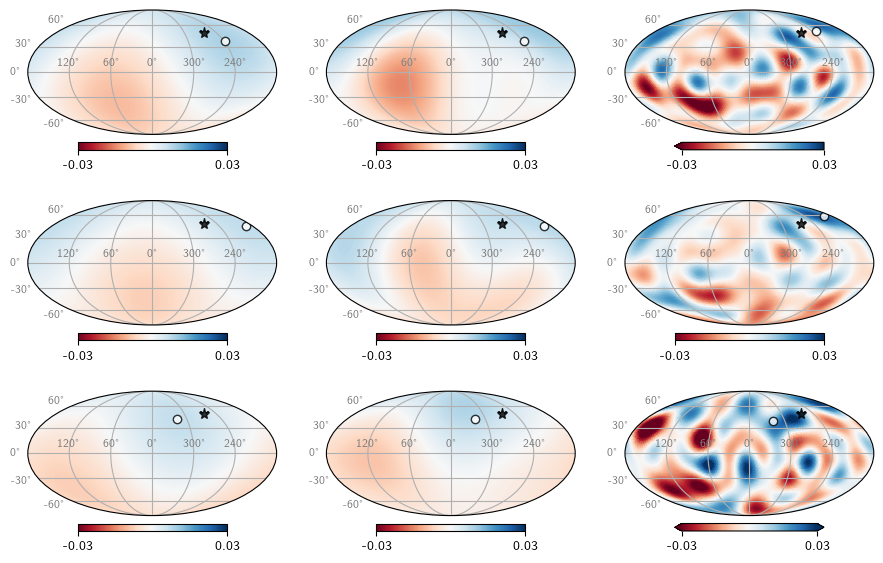

In [49]:
# plott
fig = plt.figure(figsize=(3 * len(max_ells), 6))

kwargs = dict(coord=['C','G'], min=-.03, max=.03, fig=fig, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
             fontsize={'xtick_label':8, 'ytick_label':8})

for i, max_ell_ in enumerate(max_ells):
    hp.projview(reconstructed_maps_catwise[i], sub=(3, len(max_ells), i+1),
                title='', **kwargs)
    tools.plot_marker(dipdirs_catwise[i].galactic.l, dipdirs_catwise[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
    hp.projview(reconstructed_maps_sf_catwise[i], sub=(3, len(max_ells), i+4),
                title='', **kwargs)
    tools.plot_marker(dipdirs_sf_catwise[i].galactic.l, dipdirs_sf_catwise[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
    hp.projview(reconstructed_maps_quaia[i], sub=(3, len(max_ells), i+7),
                title='', **kwargs)
    tools.plot_marker(dipdirs_quaia[i].galactic.l, dipdirs_quaia[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)

for plot on slides - want separate plots for easier animation

In [50]:
# where to store the reconstructed maps, AND the recovered dipole direction
reconstructed_maps_quaia_Lambda0 = np.empty((len(max_ells), d_quaia.NPIX))
dipdirs_quaia_Lambda0 = []
for i, max_ell_ in enumerate(max_ells):

    _, _, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                              Lambda=0, max_ell=max_ell_, 
                                                              selfunc=selfunc_quaia, return_alms=True)
    reconstructed_maps_quaia_Lambda0[i] = multipoles.reconstruct_map(alms, d_quaia.NSIDE)
    dipdirs_quaia_Lambda0.append(dipole.get_dipole(alms[1:4], from_alms=True)[1])

1
2
8


<Figure size 400x300 with 0 Axes>

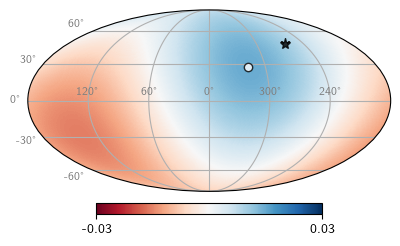

<Figure size 400x300 with 0 Axes>

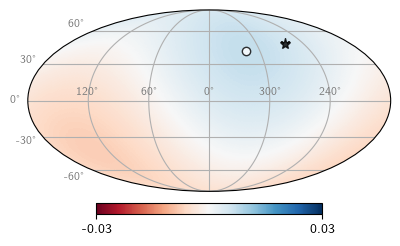

<Figure size 400x300 with 0 Axes>

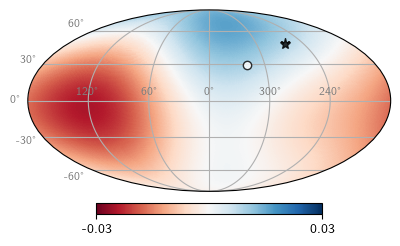

<Figure size 400x300 with 0 Axes>

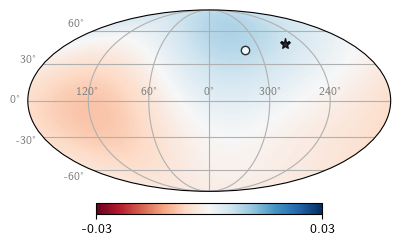

<Figure size 400x300 with 0 Axes>

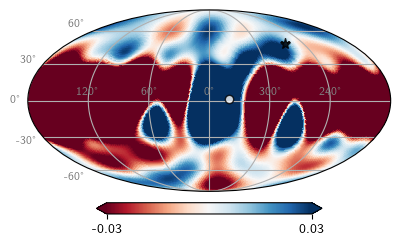

<Figure size 400x300 with 0 Axes>

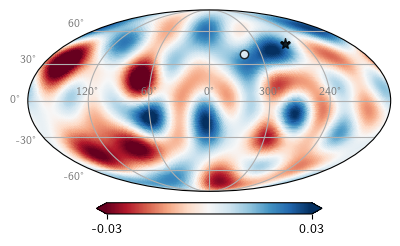

In [71]:
# plott
kwargs = dict(coord=['C','G'], min=-.03, max=.03, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
              fontsize={'xtick_label':8, 'ytick_label':8},
              width=4,
              )

for i, max_ell_ in enumerate(max_ells):
    print(max_ell_, flush=True)

    fig = plt.figure(figsize=(4,3))
    _ = hp.projview(reconstructed_maps_quaia_Lambda0[i], fig=fig,
                title='', **kwargs)
    tools.plot_marker(dipdirs_quaia_Lambda0[i].galactic.l, dipdirs_quaia_Lambda0[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)   

    fig = plt.figure(figsize=(4,3))
    _ = hp.projview(reconstructed_maps_quaia[i], fig=fig,
                title='', **kwargs)
    tools.plot_marker(dipdirs_quaia[i].galactic.l, dipdirs_quaia[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
    
 

### compare Cells with our regularization to Cells with standard / Secrest's fitting

In [72]:
# Cells with our regularization have already been computed above

In [73]:
# with standard / Secrest's fitting: we just exclude masked pixels from the fit:
# *Lambda is zero in this case!!
ells, Cells_standard_catwise = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_elat_catwise,
                                                                           Lambda=0., max_ell=max_ell, selfunc=None,
                                                                           idx_to_fit=~np.isnan(overdensity_map_elat_catwise))
                                                                            # * this last idx_to_fit makes Wmask irrelevant in the fit
ells, Cells_standard_sf_catwise = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                                           Lambda=0., max_ell=max_ell, selfunc=selfunc_catwise,
                                                                           idx_to_fit=~np.isnan(overdensity_map_sf_catwise))
ells, Cells_standard_quaia = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                                         Lambda=0., max_ell=max_ell, selfunc=selfunc_quaia,
                                                                         idx_to_fit=~np.isnan(overdensity_map_sf_quaia))

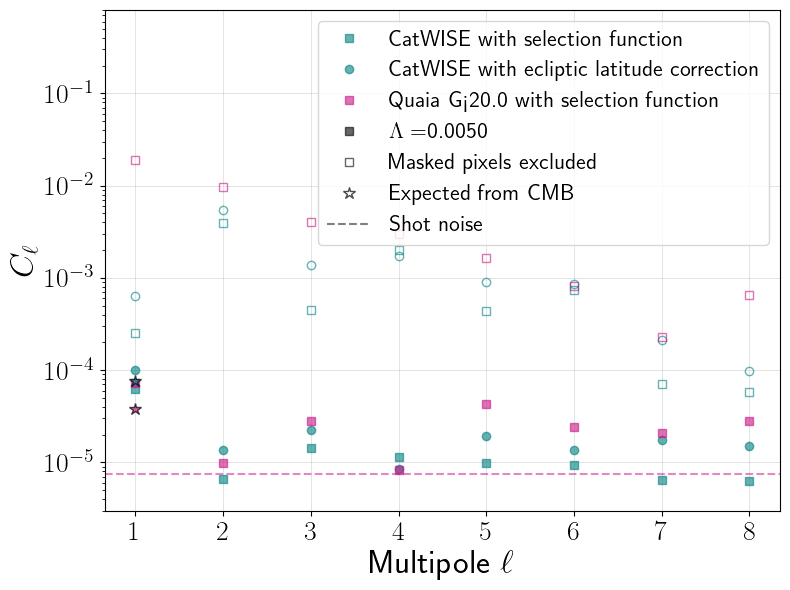

In [74]:
# plottt
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6)
ax.plot(ells[1:], Cells_sf_catwise[1:], label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
ax.plot(ells[1:], Cells_catwise[1:], label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='o', **kwargs)
ax.plot(ells[1:], Cells_quaia[1:], c=color_quaia, label='Quaia G<20.0 with selection function', marker='s', **kwargs)

# standard fit !
ax.plot(ells[1:], Cells_standard_sf_catwise[1:], mec=color_catwise, c='None', marker='s', **kwargs)
ax.plot(ells[1:], Cells_standard_catwise[1:], mec=color_catwise, c='None', marker='o', **kwargs)
ax.plot(ells[1:], Cells_standard_quaia[1:], mec=color_quaia, c='None', marker='s', **kwargs)
# manual labels
marker = mpl.lines.Line2D([0], [0], label=r'$\Lambda=$'f'{Lambda_quaia:.4f}', c='k', marker='s', markersize=6, **kwargs)
standard_marker = mpl.lines.Line2D([0], [0], label='Masked pixels excluded', marker='s', mec='k', c='None', markersize=6, **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=9, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs)
# manual label
cmb_marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5)
ax.axhline(noise_catwise_Cell, c=color_catwise, **kwargs)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, standard_marker, cmb_marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_ylim(3e-6, 8e-1)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

### dipole amplitude as a function of regularization strength

#### CatWISE

In [75]:
# first, just the dipole:
# choose a few Lambdas / regularization strengths
Lambdas = np.logspace(-4, 2, 19)

C1s_elat_catwise = np.empty_like(Lambdas)
C1s_sf_catwise = np.empty_like(Lambdas)
for i, Lambda_ in enumerate(Lambdas):
    # compute the Cells and store the dipole amplitude:

    # ecliptic latitude corrected
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_elat_catwise,
                                                              Lambda=Lambda_, max_ell=1, selfunc=None)
    C1s_elat_catwise[i] = Cells[1]

    # selection function corrected
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                              Lambda=Lambda_, max_ell=1, selfunc=selfunc_catwise)
    C1s_sf_catwise[i] = Cells[1]

# and "standard" fits:
# ecliptic latitude corrected:
ells_, Cells_standard_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_elat_catwise,
                                                                     Lambda=0., max_ell=1, selfunc=None,
                                                                     idx_to_fit=~np.isnan(overdensity_map_elat_catwise))
C1_standard_catwise = Cells_standard_[1]
ells_, Cells_sf_standard_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                                     Lambda=0., max_ell=1, selfunc=selfunc_catwise,
                                                                     idx_to_fit=~np.isnan(overdensity_map_sf_catwise))
C1_standard_sf_catwise = Cells_sf_standard_[1]

In [76]:
print(expected_dipamp_catwise)
print(D(C1_standard_catwise)/expected_dipamp_catwise)
print(D(C1_standard_sf_catwise)/expected_dipamp_catwise)
#print(D(C1s_quaia[np.argmin(np.abs(Wmasks-0.1))])/expected_dipamp_quaia)

0.00735992890678722
1.737957738740086
1.4310035651589499


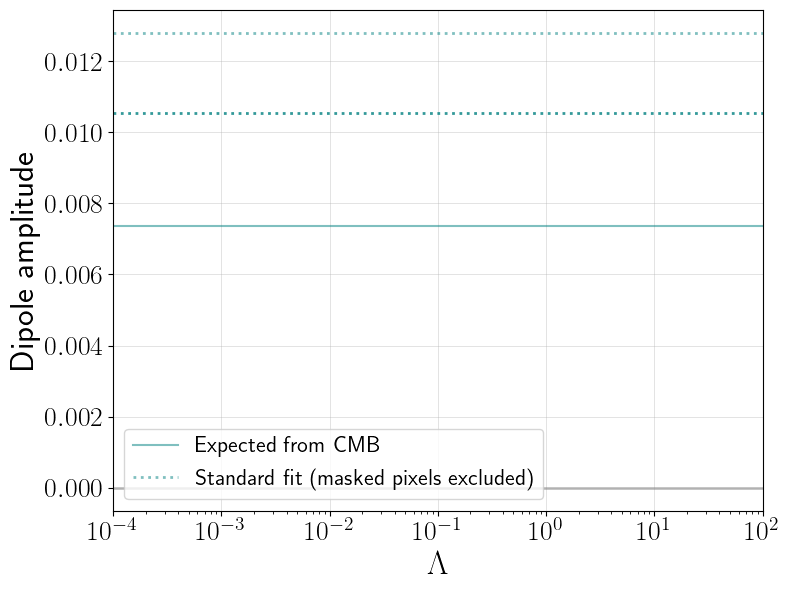

In [77]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

# some lines:
ax.axhline(expected_dipamp_catwise, c=color_catwise, alpha=0.5, label='Expected from CMB')
ax.axhline(D(C1_standard_catwise), c=color_catwise, alpha=0.5, ls=':', lw=lw, label='Standard fit (masked pixels excluded)')
ax.axhline(D(C1_standard_sf_catwise), c=color_catwise, alpha=0.8, ls=':', lw=lw)
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
ax.set_xlim(np.min(Lambdas), np.max(Lambdas))

#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.semilogx()
ax.legend(loc='lower left')

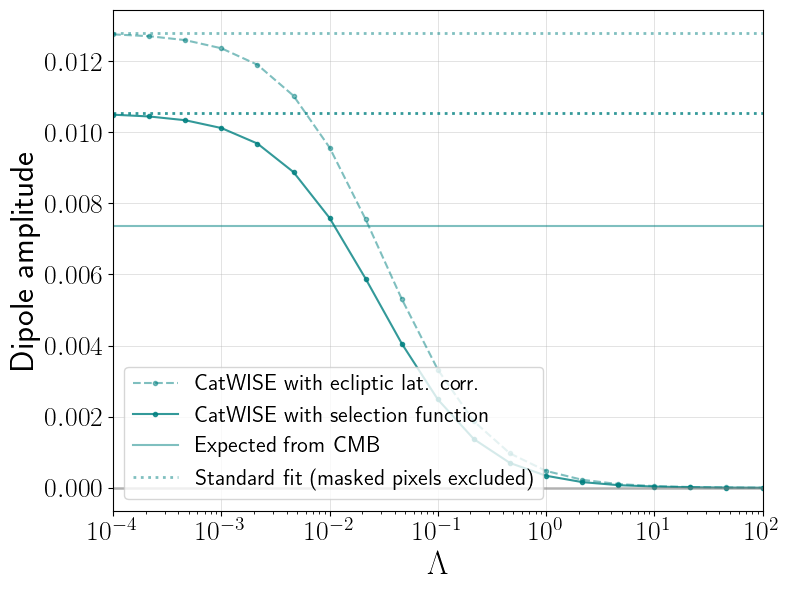

In [78]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

ax.plot(Lambdas, D(C1s_elat_catwise), c=color_catwise, alpha=0.5, ls='--', marker='.', label='CatWISE with ecliptic lat. corr.')
ax.plot(Lambdas, D(C1s_sf_catwise), c=color_catwise, alpha=0.8, marker='.', label='CatWISE with selection function')

# some lines:
ax.axhline(expected_dipamp_catwise, c=color_catwise, alpha=0.5, label='Expected from CMB')
ax.axhline(D(C1_standard_catwise), c=color_catwise, alpha=0.5, ls=':', lw=lw, label='Standard fit (masked pixels excluded)')
ax.axhline(D(C1_standard_sf_catwise), c=color_catwise, alpha=0.8, ls=':', lw=lw)
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.set_xlim(np.min(Lambdas), np.max(Lambdas))

ax.semilogx()
ax.legend(loc='lower left')

In [79]:
# choose a few max ells
max_ells_maxells = np.arange(1, 5).astype(int)

# and Lambdas / regularization strengths
Lambdas_maxells = np.logspace(-4, 1, 19)

In [80]:
C1s_elat_catwise_maxells = np.empty((len(max_ells_maxells), len(Lambdas_maxells)))
C1s_sf_catwise_maxells = np.empty((len(max_ells_maxells), len(Lambdas_maxells)))
for i, max_ell_ in enumerate(max_ells_maxells):
    for j, Lambda_ in enumerate(Lambdas_maxells):
        print(f"max_ell = {max_ell_}, Lambda = {Lambda_}", end='\r')
    
        # ecliptic latitude corrected
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_elat_catwise,
                                                                  Lambda=Lambda_, max_ell=max_ell_, selfunc=None)
        C1s_elat_catwise_maxells[i,j] = Cells[1]
    
        # selection function corrected
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                                  Lambda=Lambda_, max_ell=max_ell_, selfunc=selfunc_catwise)
        C1s_sf_catwise_maxells[i,j] = Cells[1]

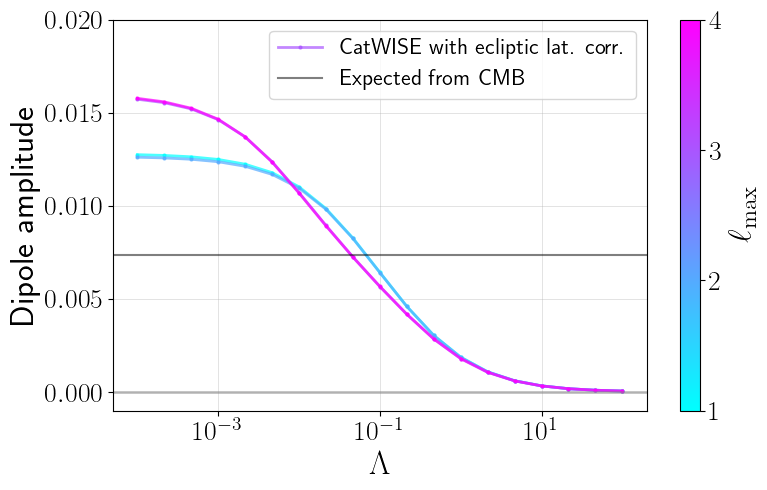

In [81]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells):
    label = 'CatWISE with ecliptic lat. corr.' if i==len(max_ells)-1 else ''
    ax.plot(Lambdas, D(C1s_elat_catwise_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, marker='.', ms=4,
           label=label, lw=lw)

ax.axhline(expected_dipamp_catwise, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
ax.legend(loc='upper right')
#ax.legend(loc='lower left')
ax.set_ylim(-0.001, 0.02)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

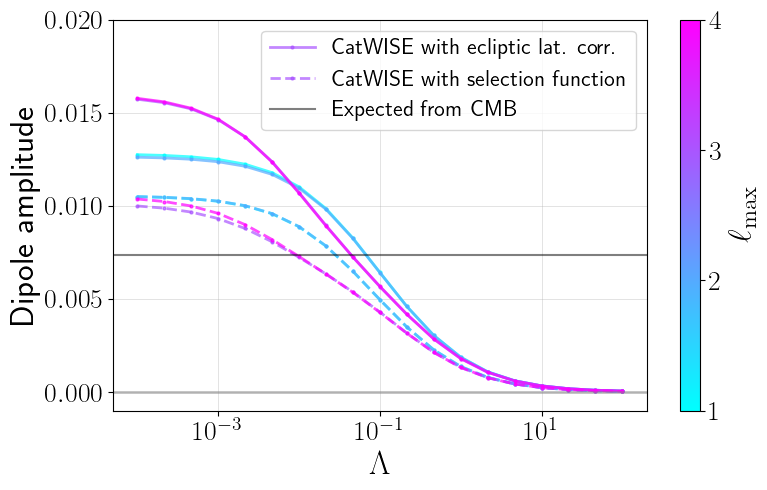

In [82]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells):
    label = 'CatWISE with ecliptic lat. corr.' if i==len(max_ells)-1 else ''
    ax.plot(Lambdas, D(C1s_elat_catwise_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, marker='.', ms=4,
           label=label, lw=lw)
    label = 'CatWISE with selection function' if i==len(max_ells)-1 else ''
    ax.plot(Lambdas, D(C1s_sf_catwise_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, marker='.', ms=4, ls='--',
           label=label, lw=lw)

ax.axhline(expected_dipamp_catwise, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
#ax.legend(loc='lower left')
ax.legend(loc='upper right')
ax.set_ylim(-0.001, 0.02)
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

### Quaia

In [282]:
# first, just the dipole:

C1s_quaia = np.empty_like(Lambdas)
for i, Lambda_ in enumerate(Lambdas):
    # compute the Cells and store the dipole amplitude:

    # ecliptic latitude corrected
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                               Lambda=Lambda_,  max_ell=1, selfunc=selfunc_quaia)
    C1s_quaia[i] = Cells[1]

# and "standard" fits:
ells_, Cells_standard_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                                     Lambda=0., max_ell=1, selfunc=selfunc_quaia,
                                                                     idx_to_fit=~np.isnan(overdensity_map_sf_quaia))
C1_standard_quaia = Cells_standard_[1]

In [283]:
D(C1_standard_quaia)

0.012902720750861097

In [284]:
print(expected_dipamp_quaia)
print(D(C1_standard_quaia)/expected_dipamp_quaia)
print(D(C1s_quaia[np.argmin(np.abs(Lambdas-Lambda_quaia))])/expected_dipamp_quaia)

0.0052320620380167755
2.466087110035855
1.8987312614040588


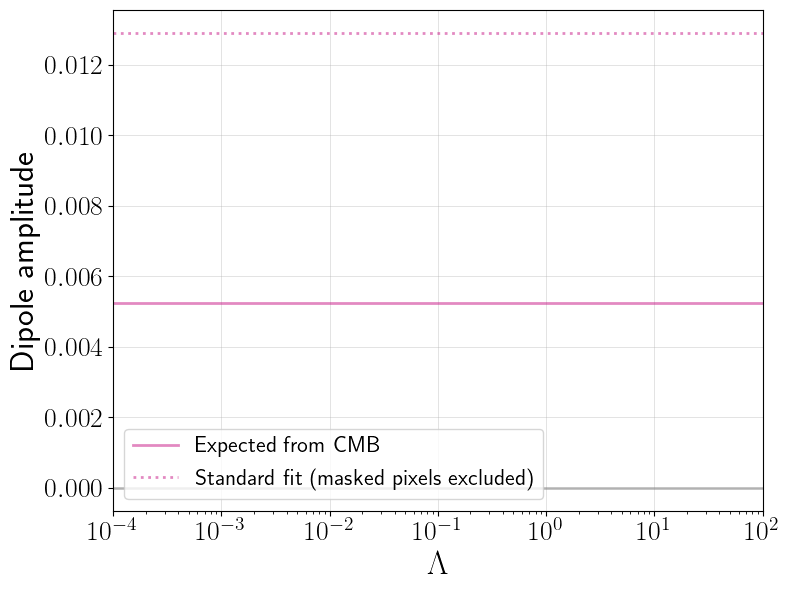

In [285]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

# some lines:
ax.axhline(expected_dipamp_quaia, c=color_quaia, alpha=0.5, lw=lw, label='Expected from CMB')
ax.axhline(D(C1_standard_quaia), c=color_quaia, alpha=0.5,  lw=lw, ls=':', label='Standard fit (masked pixels excluded)')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.semilogx()
ax.set_xlim(np.min(Lambdas), np.max(Lambdas))

ax.legend(loc='lower left')

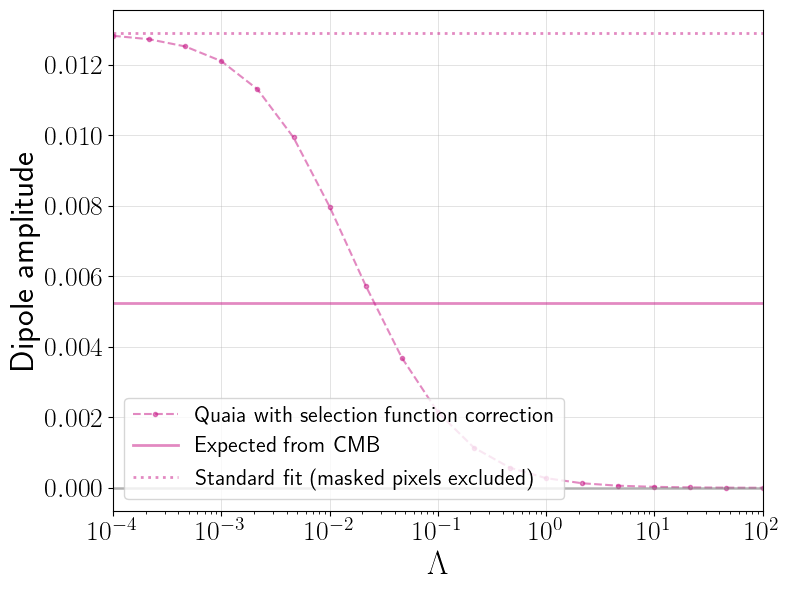

In [286]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

ax.plot(Lambdas, D(C1s_quaia), c=color_quaia, alpha=0.5, ls='--', marker='.', 
        label='Quaia with selection function correction')

# some lines:
ax.axhline(expected_dipamp_quaia, c=color_quaia, alpha=0.5, lw=lw, label='Expected from CMB')
ax.axhline(D(C1_standard_quaia), c=color_quaia, alpha=0.5, lw=lw, ls=':',label='Standard fit (masked pixels excluded)')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.semilogx()
ax.set_xlim(np.min(Lambdas), np.max(Lambdas))
ax.legend(loc='lower left')

In [287]:
C1s_quaia_maxells = np.empty((len(max_ells_maxells), len(Lambdas_maxells)))
for i, max_ell_ in enumerate(max_ells_maxells):
    for j, Lambda_ in enumerate(Lambdas_maxells):
        print(f"max_ell = {max_ell_}, Lambda_ = {Lambda_}", end='\r')
    
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                                  Lambda=Lambda_, max_ell=max_ell_, 
                                                                  selfunc=selfunc_quaia)
        C1s_quaia_maxells[i,j] = Cells[1]

In [ ]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells[:1]):
    label = 'Quaia with selection function' if i==len(max_ells)-1 else ''
    ax.plot(Lambdas, D(C1s_quaia_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, lw=lw, marker='.', ms=4, ls='-',
           label=label)

ax.axhline(expected_dipamp_quaia, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
ax.legend(loc='upper right')
ax.set_ylim(-0.0015, 0.037)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

In [ ]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells):
    label = 'Quaia with selection function' if i==len(max_ells)-1 else ''
    ax.plot(Lambdas, D(C1s_quaia_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, lw=lw, marker='.', ms=4, ls='-',
           label=label)

ax.axhline(expected_dipamp_quaia, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
ax.legend(loc='upper right')
ax.set_ylim(-0.0015, 0.037)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

## C_ells for diff lmaxes with noise-matched Lambdas

In [272]:
# choose a few max ells
max_ells_all = np.arange(1, max_ell+1)

# where to store the reconstructed maps, AND the recovered dipole direction
ells_maxells_all = []
Cells_maxells_all_quaia = []
for i, max_ell_ in enumerate(max_ells_all):
    print(f"lmax={max_ell_}, Lambda={Lambdas_dict_quaia[max_ell_]}")

    # Quaia
    ells_maxells_all_, Cells_maxells_all_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_quaia,
                                                              Lambda=Lambdas_dict_quaia[max_ell_], max_ell=max_ell_, 
                                                              selfunc=selfunc_quaia)
    ells_maxells_all.append(ells_maxells_all_)
    Cells_maxells_all_quaia.append(Cells_maxells_all_)


lmax=1, Lambda=0.018197008586099832
lmax=2, Lambda=0.018197008586099832
lmax=3, Lambda=0.013182567385564073
lmax=4, Lambda=0.013182567385564073
lmax=5, Lambda=0.007244359600749898
lmax=6, Lambda=0.007244359600749898
lmax=7, Lambda=0.004365158322401661
lmax=8, Lambda=0.005011872336272725


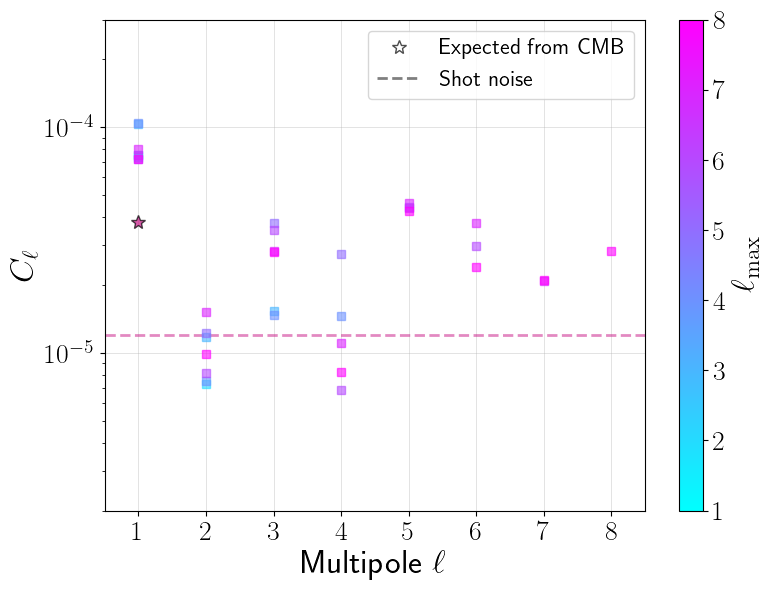

In [274]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)

norm = mpl.colors.Normalize(vmin=min(max_ells_all), vmax=max(max_ells_all))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

for i, max_ell_ in enumerate(max_ells_all):

    ax.errorbar(ells_maxells_all[i][1:], Cells_maxells_all_quaia[i][1:], 
                #yerr=Cells_quaia_std[1:],
                yerr = None,
                c=smap.to_rgba(max_ell_), 
                #c=color_quaia,
                marker='s', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
#ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_all)

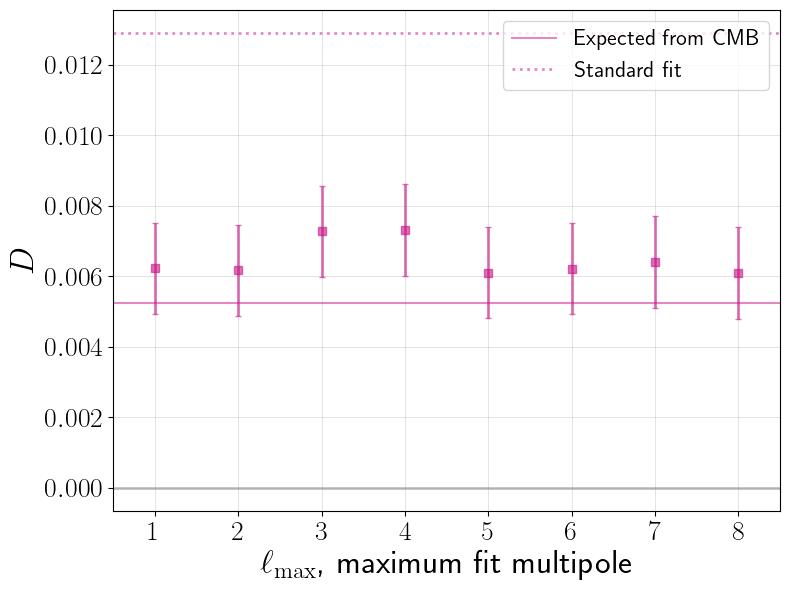

In [290]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)

norm = mpl.colors.Normalize(vmin=min(max_ells_all), vmax=max(max_ells_all))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

# 1 is dipole
Ds_maxells_all = []
for i in range(len(Cells_maxells_all_quaia)):
    Ds_maxells_all.append( D(Cells_maxells_all[i][1]) )

D_errs = D_err(Cells_maxells_all_quaia[i][1], Cells_quaia_std[1])
ax.errorbar(max_ells_all, Ds_maxells_all,
            #c=smap.to_rgba(max_ell_), 
            c=color_quaia,
            #yerr=None,
            yerr=D_errs,
                #label=r'Quaia $G<20.0$ with selection function', 
                #label=f'lmax={max_ell_}',
                marker='s', **kwargs)

ax.axhline(expected_dipamp_quaia, c=color_quaia, alpha=0.5, label='Expected from CMB')
ax.axhline(D(C1_standard_quaia), c=color_quaia, alpha=0.5, lw=lw, ls=':',label='Standard fit')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)

#ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
#ax.set_ylim(0, 0.01)
ax.set_xlabel(r'$\ell_\mathrm{max}$, maximum fit multipole')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$D$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1)

### Catwise

In [291]:
# choose a few max ells
max_ells_all = np.arange(1, max_ell+1)

# where to store the reconstructed maps, AND the recovered dipole direction
ells_maxells_all = []
Cells_maxells_all_catwise = []
for i, max_ell_ in enumerate(max_ells_all):
    print(f"lmax={max_ell_}, Lambda={Lambdas_dict_catwise[max_ell_]}")

    # Quaia
    ells_maxells_all_, Cells_maxells_all_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_sf_catwise,
                                                              Lambda=Lambdas_dict_catwise[max_ell_], max_ell=max_ell_, 
                                                              selfunc=selfunc_catwise)
    ells_maxells_all.append(ells_maxells_all_)
    Cells_maxells_all_catwise.append(Cells_maxells_all_)


lmax=1, Lambda=0.017378008287493755
lmax=2, Lambda=0.017378008287493755
lmax=3, Lambda=0.013182567385564073
lmax=4, Lambda=0.013182567385564073
lmax=5, Lambda=0.007585775750291836
lmax=6, Lambda=0.007585775750291836
lmax=7, Lambda=0.004570881896148751
lmax=8, Lambda=0.005011872336272725


In [293]:
# choose a few max ells
max_ells_all = np.arange(1, max_ell+1)

# where to store the reconstructed maps, AND the recovered dipole direction
ells_maxells_all = []
Cells_maxells_all_catwise_elat = []
for i, max_ell_ in enumerate(max_ells_all):
    print(f"lmax={max_ell_}, Lambda={Lambdas_dict_catwise[max_ell_]}")

    # Quaia
    ells_maxells_all_, Cells_maxells_all_ = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_catwise,
                                                              Lambda=Lambdas_dict_catwise[max_ell_], max_ell=max_ell_, 
                                                              selfunc=None)
    ells_maxells_all.append(ells_maxells_all_)
    Cells_maxells_all_catwise_elat.append(Cells_maxells_all_)


lmax=1, Lambda=0.017378008287493755
lmax=2, Lambda=0.017378008287493755
lmax=3, Lambda=0.013182567385564073
lmax=4, Lambda=0.013182567385564073
lmax=5, Lambda=0.007585775750291836
lmax=6, Lambda=0.007585775750291836
lmax=7, Lambda=0.004570881896148751
lmax=8, Lambda=0.005011872336272725


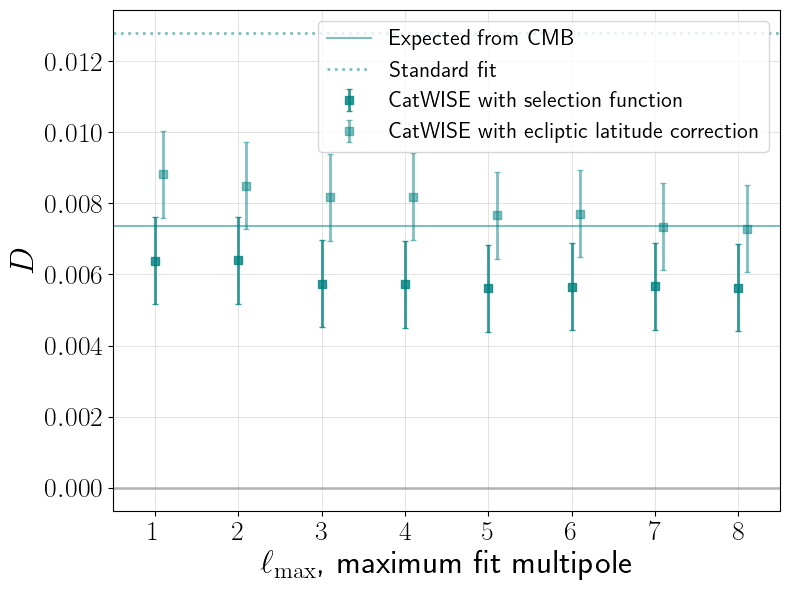

In [298]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, capsize=2, lw=lw)

norm = mpl.colors.Normalize(vmin=min(max_ells_all), vmax=max(max_ells_all))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

# 1 is dipole
Ds_maxells_all = []
Ds_maxells_all_elat = []
for i in range(len(Cells_maxells_all_catwise)):
    Ds_maxells_all.append( D(Cells_maxells_all_catwise[i][1]) )
    Ds_maxells_all_elat.append( D(Cells_maxells_all_catwise_elat[i][1]) )

D_errs = D_err(Cells_maxells_all_catwise[i][1], Cells_catwise_std[1])
D_errs_elat = D_err(Cells_maxells_all_catwise[i][1], Cells_catwise_std[1])

ax.errorbar(max_ells_all, Ds_maxells_all,
            label='CatWISE with selection function',
            #c=smap.to_rgba(max_ell_), 
            alpha=0.8,
            c=color_catwise,
            #yerr=None,
            yerr=D_errs,
                #label=r'Quaia $G<20.0$ with selection function', 
                #label=f'lmax={max_ell_}',
                marker='s', **kwargs)

ax.errorbar(max_ells_all+0.1, Ds_maxells_all_elat,
            label='CatWISE with ecliptic latitude correction',
            #c=smap.to_rgba(max_ell_), 
            alpha=0.5,
            c=color_catwise,
            #yerr=None,
            yerr=D_errs_elat,
                #label=r'Quaia $G<20.0$ with selection function', 
                #label=f'lmax={max_ell_}',
                marker='s', **kwargs)

ax.axhline(expected_dipamp_catwise, c=color_catwise, alpha=0.5, label='Expected from CMB')
ax.axhline(D(C1_standard_catwise), c=color_catwise, alpha=0.5, lw=lw, ls=':',label='Standard fit')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)

#ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
#ax.set_ylim(0, 0.01)
ax.set_xlabel(r'$\ell_\mathrm{max}$, maximum fit multipole')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$D$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1)

## Noise maps

In [119]:
masked_datamap_quaia = d_quaia.construct_masked_datamap(selfunc=selfunc_quaia, return_map=True)

defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


In [121]:
#mu = np.nanmean(masked_datamap)
mu = np.nanmean(masked_datamap_quaia)
print(mu)
noise = np.random.poisson(mu, hp.nside2npix(d_quaia.NSIDE)).astype(float)
#noise[~mask] = np.nan

33.63190694514304


In [124]:
print(np.mean(noise), np.std(noise))

33.592569986979164 5.820123400450287


In [122]:
noise_cut = noise.copy()
noise_cut[~d_quaia.mask] = np.nan

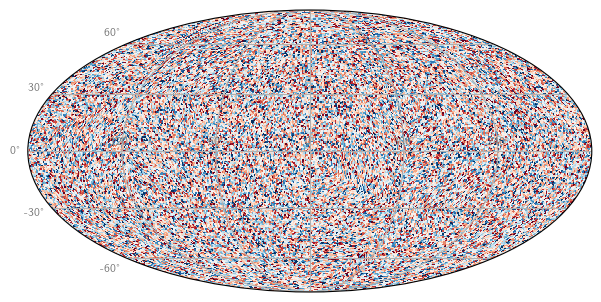

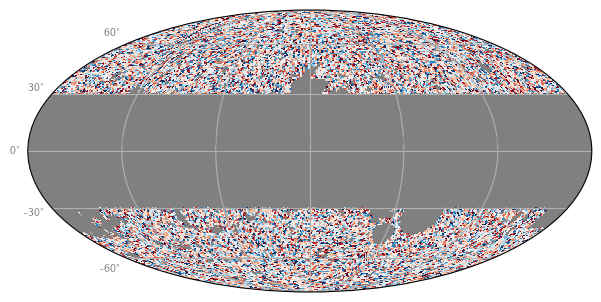

In [130]:
kwargs = dict(coord=['C','G'], 
              min=np.mean(noise)-2*np.std(noise),
              max=np.mean(noise)+2*np.std(noise),
              fig=fig, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
             fontsize={'xtick_label':8, 'ytick_label':8},
             width=6, cbar=None)

hp.projview(noise, **kwargs)

hp.projview(noise_cut, **kwargs)